In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
import json

# Загрузка (замените на ваш CSV)
df = pd.read_csv('S06-hw-dataset-04.csv')
print("shape:", df.shape)
print(df['target'].value_counts(normalize=True))  # Покажет дисбаланс, напр. 5% positive
X = df.drop(['target', 'id'], axis=1)
y = df['target']


shape: (25000, 62)
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64


In [3]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# --- split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- models + grids (быстро, без зависаний) ---
models = {
    "Dummy": (
        DummyClassifier(),
        {"strategy": ["stratified"]},
    ),
    "LogisticRegression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),
        {"clf__C": [1.0, 10.0]},
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_leaf': [5, 10, 20],
            'min_samples_split': [10, 20, 50],
            'ccp_alpha': [0.0, 0.001, 0.01],
            'max_leaf_nodes': [None, 10, 20],
            'min_impurity_decrease': [0.0, 0.001]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [100],
            "max_depth": [10, None],
            "min_samples_leaf": [1, 10],
        },
    ),
    "Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [100],
            "learning_rate": [0.1],
            "max_depth": [2, 3],
        },
    ),
}

scoring = {
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
}

metrics_test = {}
best_key = None
best_cv = -np.inf

for key, (estimator, grid) in models.items():
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring=scoring,
        refit="pr_auc",
        cv=5,
        n_jobs=-1,        # <-- важно: меньше зависаний на Windows
        verbose=1
    )
    gs.fit(X_train, y_train)

    idx = gs.best_index_
    metrics_test[key] = {
        "best_params": gs.best_params_,
        "cv_score": float(gs.best_score_),
        "accuracy": float(gs.cv_results_["mean_test_accuracy"][idx]),
        "f1": float(gs.cv_results_["mean_test_f1"][idx]),
        "roc_auc": float(gs.cv_results_["mean_test_roc_auc"][idx]),
        "pr_auc": float(gs.cv_results_["mean_test_pr_auc"][idx]),
    }

    if metrics_test[key]["cv_score"] > best_cv:
        best_cv = metrics_test[key]["cv_score"]
        best_key = key

# --- test: считаем только для лучшей модели, строго после выбора ---
best_estimator, _ = models[best_key]
best_model = best_estimator.set_params(**metrics_test[best_key]["best_params"])
best_model.fit(X_train, y_train)

probs = best_model.predict_proba(X_test)[:, 1]
pred = (probs >= 0.5).astype(int)

test_acc = float(accuracy_score(y_test, pred))
test_f1  = float(f1_score(y_test, pred))
test_roc = float(roc_auc_score(y_test, probs))
test_pr  = float(average_precision_score(y_test, probs))

best_model_meta = {
    "best_model": best_key,
    "params": metrics_test[best_key]["best_params"],
    "cv_score": float(metrics_test[best_key]["cv_score"]),
    "test_metrics": {
        "accuracy": test_acc,
        "f1": test_f1,
        "roc_auc": test_roc,
        "pr_auc": test_pr,
    }
}

# --- save artifacts ---
os.makedirs("artifacts", exist_ok=True)

with open("artifacts/metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, indent=2, ensure_ascii=False)

with open("artifacts/best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

print("Best model:", best_key)
print("Best CV PR-AUC:", best_cv)
print("Test metrics:", best_model_meta["test_metrics"])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best model: RandomForest
Best CV PR-AUC: 0.7210509366689788
Test metrics: {'accuracy': 0.9738, 'f1': 0.6391184573002755, 'roc_auc': 0.9016472221937195, 'pr_auc': 0.768782866968498}


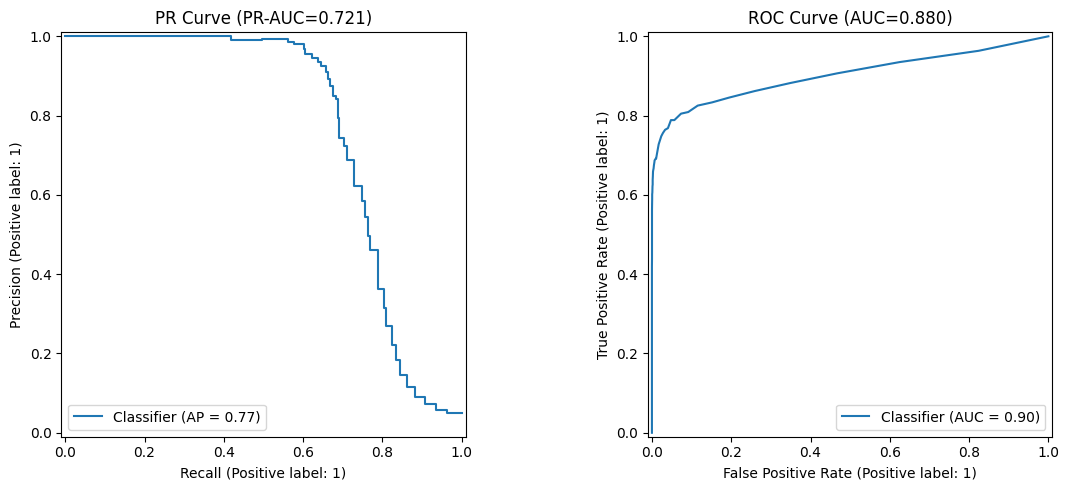

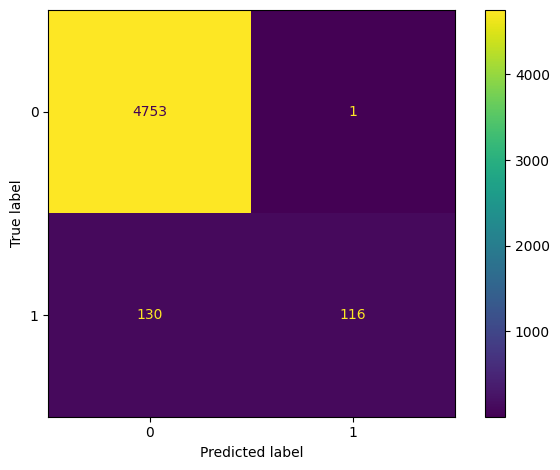

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1) собираем "чистую" лучшую модель из models + best_params
best_name = best_key
best_params = metrics_test[best_name]["best_params"]

estimator, _grid = models[best_name]
best_model = estimator.set_params(**best_params)
best_model.fit(X_train, y_train)

# 2) предсказания
probs = best_model.predict_proba(X_test)[:, 1]
pred = (probs >= 0.5).astype(int)

# 3) PR/ROC
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay.from_predictions(y_test, probs, ax=ax[0])
ax[0].set_title(f"PR Curve (PR-AUC={metrics_test[best_name]['pr_auc']:.3f})")
RocCurveDisplay.from_predictions(y_test, probs, ax=ax[1])
ax[1].set_title(f"ROC Curve (AUC={metrics_test[best_name]['roc_auc']:.3f})")
plt.tight_layout()
plt.show()

# 4) Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.tight_layout()
plt.show()


Лучшая модель: RandomForest
Test metrics:
Accuracy: 0.974
F1: 0.639
ROC-AUC: 0.902
PR-AUC: 0.769


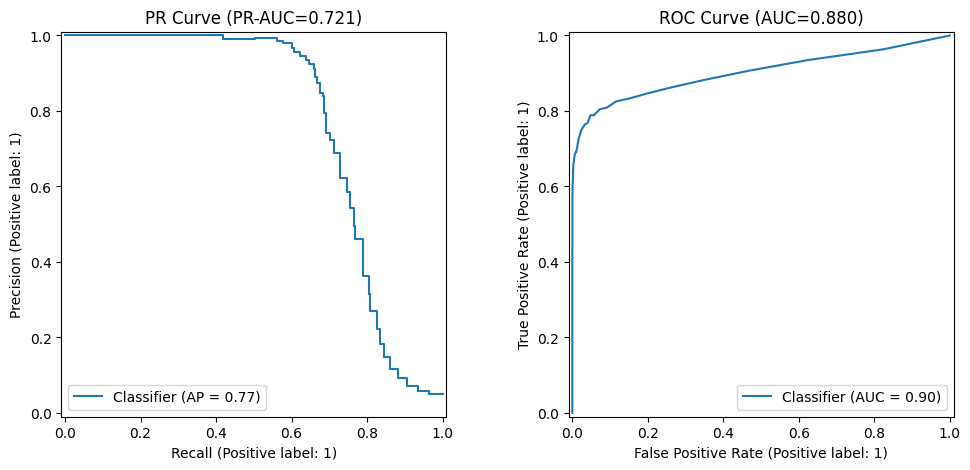

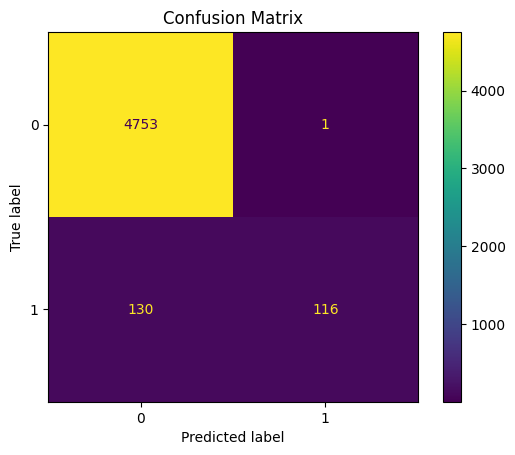

['artifacts/best_model.joblib']

In [5]:
# ===== ГРАФИКИ + АРТЕФАКТЫ (правильно для текущего пайплайна) =====
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

# 1) Собираем и обучаем ЛУЧШУЮ модель заново (по best_key и best_params)
best_name = best_key
best_params = metrics_test[best_name]["best_params"]

estimator, _grid = models[best_name]
best_model = estimator.set_params(**best_params)
best_model.fit(X_train, y_train)

# 2) Предсказания
probs = best_model.predict_proba(X_test)[:, 1]
pred = (probs >= 0.5).astype(int)

print(f"Лучшая модель: {best_name}")
print("Test metrics:")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, probs):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, probs):.3f}")

# 3) Папки
os.makedirs("artifacts/figures", exist_ok=True)

# 4) PR + ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay.from_predictions(y_test, probs, ax=ax1)
ax1.set_title(f"PR Curve (PR-AUC={metrics_test[best_name]['pr_auc']:.3f})")
RocCurveDisplay.from_predictions(y_test, probs, ax=ax2)
ax2.set_title(f"ROC Curve (AUC={metrics_test[best_name]['roc_auc']:.3f})")
plt.savefig("artifacts/figures/pr_roc.png", dpi=150, bbox_inches="tight")
plt.show()

# 5) Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Confusion Matrix")
plt.savefig("artifacts/figures/cm.png", dpi=150, bbox_inches="tight")
plt.show()

# 6) Permutation importance (Top-10)
perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
top_features = (
    pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean})
      .sort_values("importance", ascending=False)
      .head(10)
)
top_features.to_csv("artifacts/top_features.csv", index=False)

# 7) Сохранение модели (опционально)
joblib.dump(best_model, "artifacts/best_model.joblib")

# ВАЖНО: metrics_test.json и best_model_meta.json уже сохраняются в основной ячейке.
# Здесь их НЕ перезаписываем.
